In [1]:
import json
import pandas as pd

# Đọc train data
with open("/content/train data.json", "r", encoding="utf-8") as f: # Dùng utf-8 cho dữ liệu tiếng Việt
    train_data = json.load(f)

# Tách text, sentiment, topic
texts, sentiments, topics = [], [], []
for item in train_data:
    text = item["data"]["text"]
    sent, topic_list = None, []

    for ann in item["annotations"]:
        if ann["from_name"] == "sentiment":
            sent = ann["value"]["choices"][0]
        elif ann["from_name"] == "topic":
            topic_list.extend(ann["value"]["choices"])

    if sent:
        texts.append(text)
        sentiments.append(sent)
        topics.append(topic_list)

print(f"Số mẫu huấn luyện: {len(texts)}")

# Đọc test
test_df = pd.read_csv("/content/test.csv")
test_texts = test_df["text"].tolist()

Số mẫu huấn luyện: 1684


In [2]:
item # Mỗi mẫu có cấu trúc như sau

{'id': 785456,
 'annotations': [{'id': 'R0Ex9jrmqv',
   'type': 'choices',
   'value': {'choices': ['Trung tính']},
   'to_name': 'text',
   'from_name': 'sentiment'},
  {'id': 'f9_fOu0HNg',
   'type': 'choices',
   'value': {'choices': ['Phim ảnh']},
   'to_name': 'text',
   'from_name': 'topic'}],
 'file_upload': 'DANeS_batch_1.json',
 'data': {'meta': {'uri': 'https://vtv.vn/video/vtv-ket-noi-phim-mat-na-guong-523919.htm',
   'description': 'VTV kết nối: Phim "Mặt nạ gương".'},
  'text': 'VTV kết nối: Phim "Mặt nạ gương" - Video đã phát trên VTV1'},
 'meta': {},
 'created_at': '2021-11-19T09:02:03.835755Z',
 'updated_at': '2021-11-19T09:02:03.835762Z',
 'project': 752,
 'annotator_assigned': None,
 'reviewer_assigned': None}

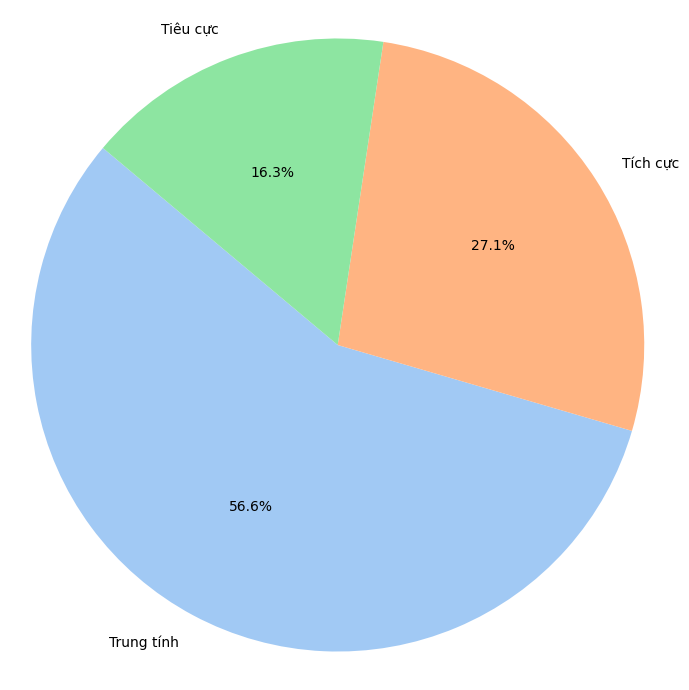

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# Tạo DataFrame từ danh sách sentiments
df_sentiment = pd.DataFrame({'sentiment': sentiments})

# Đếm số lượng từng loại sentiment
sentiment_counts = df_sentiment['sentiment'].value_counts()

# Vẽ biểu đồ tròn
plt.figure(figsize=(7, 7))
plt.pie(
    sentiment_counts.values,
    labels=sentiment_counts.index,
    autopct='%1.1f%%',  # Hiển thị phần trăm với 1 chữ số thập phân
    startangle=140,     # Góc bắt đầu để xoay biểu đồ
    colors=sns.color_palette("pastel")[0:len(sentiment_counts)]  # Màu sắc nhẹ nhàng
)

plt.axis('equal')  # Đảm bảo hình tròn hiển thị đúng tỷ lệ
plt.tight_layout()
plt.show()


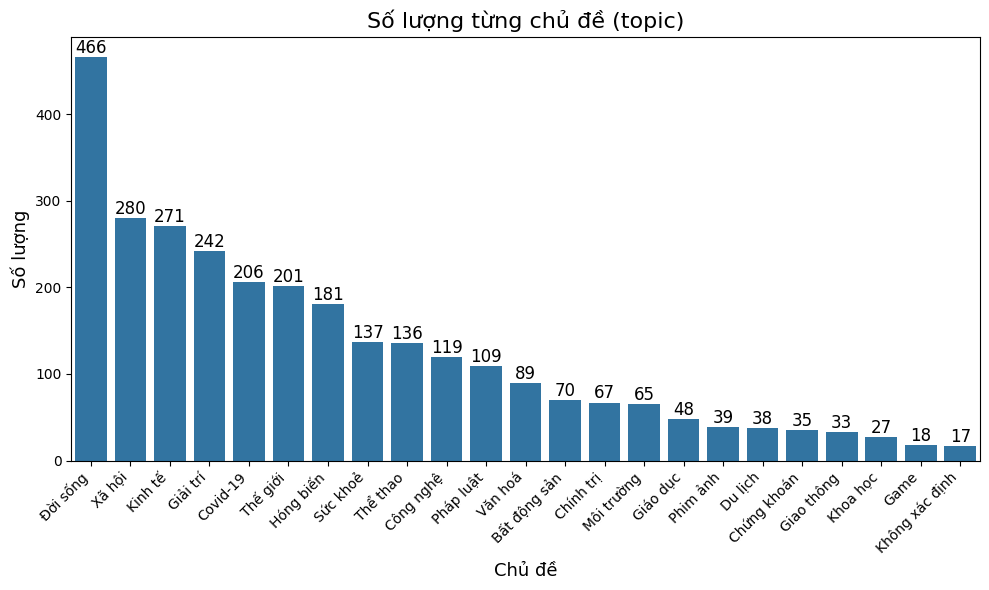

In [4]:
# Tạo DataFrame từ danh sách topics
# Flatten the list of lists in the topics variable
flat_topics = [item for sublist in topics for item in sublist]
df_topics = pd.DataFrame({'topic': flat_topics})

# Đếm số lượng mỗi topic
topic_counts = df_topics['topic'].value_counts().sort_values(ascending=False)

# Vẽ biểu đồ cột
plt.figure(figsize=(10, 6))
sns.barplot(x=topic_counts.index, y=topic_counts.values)

# Thêm tiêu đề và nhãn
plt.title("Số lượng từng chủ đề (topic)", fontsize=16)
plt.xlabel("Chủ đề", fontsize=13)
plt.ylabel("Số lượng", fontsize=13)

# Hiển thị số lượng trên từng cột
for i, v in enumerate(topic_counts.values):
    plt.text(i, v + 0.1, str(v), ha='center', va='bottom', fontsize=12)

plt.xticks(rotation=45, ha='right') # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

In [5]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base", use_fast=False) #phobert không hỗ trợ use_fast

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/557 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

bpe.codes: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

In [6]:
from sklearn.preprocessing import LabelEncoder, MultiLabelBinarizer

# Cảm xúc: Tiêu cực, Trung tính, Tích cực
le_sent = LabelEncoder()
sent_labels = le_sent.fit_transform(sentiments)

# Chủ đề: multi-label
mlb_topic = MultiLabelBinarizer()
topic_labels = mlb_topic.fit_transform(topics)
topic_names = mlb_topic.classes_

In [7]:
topic_names

array(['Bất động sản', 'Chính trị', 'Chứng khoán', 'Covid-19',
       'Công nghệ', 'Du lịch', 'Game', 'Giao thông', 'Giáo dục',
       'Giải trí', 'Hóng biến', 'Khoa học', 'Không xác định', 'Kinh tế',
       'Môi trường', 'Phim ảnh', 'Pháp luật', 'Sức khoẻ', 'Thế giới',
       'Thể thao', 'Văn hoá', 'Xã hội', 'Đời sống'], dtype=object)

In [8]:
import torch
from torch.utils.data import Dataset

class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, is_multilabel=False, max_len=256):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.is_multilabel = is_multilabel
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.texts[idx],
            padding="max_length",
            truncation=True,
            max_length=self.max_len,
            return_tensors="pt"
        )
        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "label": torch.tensor(self.labels[idx], dtype=torch.float if self.is_multilabel else torch.long)
        }


In [9]:
import torch.nn as nn
from transformers import AutoModel

class PhoBERT_Classifier(nn.Module):
    def __init__(self, num_labels, is_multilabel=False):
        super().__init__()
        self.phobert = AutoModel.from_pretrained("vinai/phobert-base")
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(self.phobert.config.hidden_size, num_labels)
        self.is_multilabel = is_multilabel

    def forward(self, input_ids, attention_mask):
        output = self.phobert(input_ids=input_ids, attention_mask=attention_mask)
        cls_token = output.last_hidden_state[:, 0, :]
        cls_token = self.dropout(cls_token)
        logits = self.classifier(cls_token)
        return logits


In [10]:
from torch.utils.data import DataLoader
import torch.nn.functional as F
import numpy as np
import copy

# Dataset và mô hình
sent_dataset = TextDataset(texts, sent_labels, tokenizer)
sent_loader = DataLoader(sent_dataset, batch_size=16, shuffle=True)
model_sent = PhoBERT_Classifier(num_labels=3).to("cuda")

# Huấn luyện
optimizer = torch.optim.AdamW(model_sent.parameters(), lr=2e-5)
loss_fn = nn.CrossEntropyLoss()
best_loss, patience = float("inf"), 0

for epoch in range(100):
    model_sent.train()
    total_loss = 0
    for batch in sent_loader:
        input_ids = batch["input_ids"].to("cuda")
        attention_mask = batch["attention_mask"].to("cuda")
        labels = batch["label"].to("cuda")

        optimizer.zero_grad()
        logits = model_sent(input_ids, attention_mask)
        loss = loss_fn(logits, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg = total_loss / len(sent_loader)
    print(f"[Sentiment Epoch {epoch+1}] Loss: {avg:.4f}")
    if avg < best_loss:
        best_loss = avg
        best_sent = copy.deepcopy(model_sent.state_dict())
        patience = 0
    else:
        patience += 1
        if patience >= 3: break

model_sent.load_state_dict(best_sent)


pytorch_model.bin:   0%|          | 0.00/543M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/543M [00:00<?, ?B/s]

[Sentiment Epoch 1] Loss: 0.9160
[Sentiment Epoch 2] Loss: 0.7462
[Sentiment Epoch 3] Loss: 0.5917
[Sentiment Epoch 4] Loss: 0.4342
[Sentiment Epoch 5] Loss: 0.3213
[Sentiment Epoch 6] Loss: 0.2250
[Sentiment Epoch 7] Loss: 0.1666
[Sentiment Epoch 8] Loss: 0.1457
[Sentiment Epoch 9] Loss: 0.0838
[Sentiment Epoch 10] Loss: 0.0666
[Sentiment Epoch 11] Loss: 0.0984
[Sentiment Epoch 12] Loss: 0.0759
[Sentiment Epoch 13] Loss: 0.0459
[Sentiment Epoch 14] Loss: 0.0419
[Sentiment Epoch 15] Loss: 0.0395
[Sentiment Epoch 16] Loss: 0.0555
[Sentiment Epoch 17] Loss: 0.0350
[Sentiment Epoch 18] Loss: 0.0474
[Sentiment Epoch 19] Loss: 0.0453
[Sentiment Epoch 20] Loss: 0.0427


<All keys matched successfully>

In [11]:
topic_dataset = TextDataset(texts, topic_labels, tokenizer, is_multilabel=True)
topic_loader = DataLoader(topic_dataset, batch_size=16, shuffle=True)
model_topic = PhoBERT_Classifier(num_labels=len(topic_names), is_multilabel=True).to("cuda")

optimizer = torch.optim.AdamW(model_topic.parameters(), lr=2e-5)
loss_fn = nn.BCEWithLogitsLoss()
best_loss, patience = float("inf"), 0

for epoch in range(100):
    model_topic.train()
    total_loss = 0
    for batch in topic_loader:
        input_ids = batch["input_ids"].to("cuda")
        attention_mask = batch["attention_mask"].to("cuda")
        labels = batch["label"].to("cuda")

        optimizer.zero_grad()
        logits = model_topic(input_ids, attention_mask)
        loss = loss_fn(logits, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg = total_loss / len(topic_loader)
    print(f"[Topic Epoch {epoch+1}] Loss: {avg:.4f}")
    if avg < best_loss:
        best_loss = avg
        best_topic = copy.deepcopy(model_topic.state_dict())
        patience = 0
    else:
        patience += 1
        if patience >= 3: break

model_topic.load_state_dict(best_topic)


[Topic Epoch 1] Loss: 0.3758
[Topic Epoch 2] Loss: 0.2910
[Topic Epoch 3] Loss: 0.2669
[Topic Epoch 4] Loss: 0.2529
[Topic Epoch 5] Loss: 0.2393
[Topic Epoch 6] Loss: 0.2198
[Topic Epoch 7] Loss: 0.1996
[Topic Epoch 8] Loss: 0.1829
[Topic Epoch 9] Loss: 0.1664
[Topic Epoch 10] Loss: 0.1531
[Topic Epoch 11] Loss: 0.1407
[Topic Epoch 12] Loss: 0.1299
[Topic Epoch 13] Loss: 0.1190
[Topic Epoch 14] Loss: 0.1091
[Topic Epoch 15] Loss: 0.1011
[Topic Epoch 16] Loss: 0.0933
[Topic Epoch 17] Loss: 0.0849
[Topic Epoch 18] Loss: 0.0777
[Topic Epoch 19] Loss: 0.0717
[Topic Epoch 20] Loss: 0.0666
[Topic Epoch 21] Loss: 0.0620
[Topic Epoch 22] Loss: 0.0568
[Topic Epoch 23] Loss: 0.0526
[Topic Epoch 24] Loss: 0.0492
[Topic Epoch 25] Loss: 0.0460
[Topic Epoch 26] Loss: 0.0425
[Topic Epoch 27] Loss: 0.0402
[Topic Epoch 28] Loss: 0.0377
[Topic Epoch 29] Loss: 0.0350
[Topic Epoch 30] Loss: 0.0329
[Topic Epoch 31] Loss: 0.0307
[Topic Epoch 32] Loss: 0.0288
[Topic Epoch 33] Loss: 0.0273
[Topic Epoch 34] Lo

<All keys matched successfully>

In [12]:
model_sent.eval()
model_topic.eval()

# Sentiment
sent_preds = []
with torch.no_grad():
    for i in range(0, len(test_texts), 16):
        enc = tokenizer(test_texts[i:i+16], padding=True, truncation=True, max_length=256, return_tensors="pt")
        input_ids = enc["input_ids"].to("cuda")
        attention_mask = enc["attention_mask"].to("cuda")
        logits = model_sent(input_ids, attention_mask)
        preds = torch.argmax(logits, dim=1).cpu().numpy()
        sent_preds.extend(preds)

pred_sentiments = le_sent.inverse_transform(sent_preds)

# Topic
topic_preds = []
with torch.no_grad():
    for i in range(0, len(test_texts), 16):
        enc = tokenizer(test_texts[i:i+16], padding=True, truncation=True, max_length=256, return_tensors="pt")
        input_ids = enc["input_ids"].to("cuda")
        attention_mask = enc["attention_mask"].to("cuda")
        logits = model_topic(input_ids, attention_mask)
        probs = torch.sigmoid(logits).cpu().numpy()
        labels = (probs > 0.4).astype(int)
        for row in labels:
            selected_topics = [topic_names[i] for i in range(len(topic_names)) if row[i] == 1]
            if selected_topics:
              topics_str = ";".join(selected_topics)
            else:
              topics_str = "unknown"
            topic_preds.append(topics_str)


# Gộp và xuất
submission = pd.DataFrame({
    "id": test_df["id"],
    "sentiment": pred_sentiments,
    "topic": topic_preds
})
submission.to_csv("/content/submission.csv", index=False, encoding="utf-8-sig")

In [18]:
# Nếu muốn lưu cả mô hình (bao gồm kiến trúc)
torch.save(model_topic, "/content/models/model_topic.pth")
torch.save(model_sent, "/content/models/model_sent.pth")

In [19]:
submission

,id,sentiment,topic
0,785456,Trung tính,Phim ảnh
1,785455,Trung tính,Giải trí;Hóng biến;Đời sống
2,785454,Trung tính,Pháp luật
3,785453,Trung tính,Giải trí;Đời sống
4,785452,Tích cực,Pháp luật
...,...,...,...
303,785122,Tích cực,Bất động sản;Kinh tế
304,785121,Trung tính,Pháp luật;Xã hội
305,785120,Tích cực,Covid-19;Xã hội;Đời sống
306,785119,Trung tính,Xã hội;Đời sống
